In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost

### Wczytanie danych

In [2]:
dt = pd.read_stata('hctms_data.dta')

### Sprawdzenie ilości NaN w danych i usunięcie ich

In [3]:
# Zmienne ilościowe
print(dt['partner_mother_yrsed'].isna().sum() / dt['partner_mother_yrsed'].count())
print(dt['partner_yrsed'].isna().sum() / dt['partner_yrsed'].count())

# Zmienne jakościowe
print(dt['Q19'].nunique())
print(dt['Q19'].isna().sum() / dt['Q19'].count())

print(dt['w6_q32'].nunique())
print(dt['w6_q32'].isna().sum() / dt['w6_q32'].count())

dt = dt[['S1','partner_mother_yrsed','partner_yrsed','w6_q32','Q19']].dropna().reset_index(drop = True)


0.05627445079747216
0.0375406443984629
3
0.22899159663865545
8
0.03417796110783736


### Przetworzenie danych i faktoryzacja zmiennych jakościowych

In [4]:
# Numerical data
partner_mother_yrsed = np.array(dt['partner_mother_yrsed']).reshape(len(dt),1)
partner_years_of_education = np.array(dt['partner_yrsed']).reshape(len(dt),1)

# S1 - Is married
y = dt['S1']
married = np.empty((len(y),1,))
married[:] = np.nan
for i in range(len(y)):
    if y[i].find('No') >= 0:
        married[i] = 0
    if y[i].find('Yes') >= 0:
        married[i] = 1

# w6_q32 - Did you use internet to meet partner?
y = dt['w6_q32']
meet_in_internet = np.empty((len(y),1,))
meet_in_internet[:] = np.nan
for i in range(len(y)):
    if y[i].find('No') >= 0:
        meet_in_internet[i] = 0
    if y[i].find('Yes') >= 0:
        meet_in_internet[i] = 1
if np.isnan(meet_in_internet).sum() != 0:
    married = married[np.argwhere(~np.isnan(meet_in_internet))[:,0]]
    partner_years_of_education = partner_years_of_education[np.argwhere(~np.isnan(meet_in_internet))[:,0]]
    partner_mother_yrsed = partner_mother_yrsed[np.argwhere(~np.isnan(meet_in_internet))[:,0]]
    meet_in_internet = meet_in_internet[np.argwhere(~np.isnan(meet_in_internet))[:,0]]
    dt = dt.loc[np.argwhere(~np.isnan(meet_in_internet))[:,0]]

# Q19 Are you currently living with your partner?
y = dt['Q19']
living_with_partner = np.empty((len(y),1,))
living_with_partner[:] = np.nan
for i in range(len(y)):
    if y[i].find('No') >= 0:
        living_with_partner[i] = 0
    if y[i].find('Yes') >= 0:
        living_with_partner[i] = 1
if np.isnan(living_with_partner).sum() != 0:
    married = married[np.argwhere(~np.isnan(living_with_partner))[:,0]]
    partner_years_of_education = partner_years_of_education[np.argwhere(~np.isnan(living_with_partner))[:,0]]
    partner_mother_yrsed = partner_mother_yrsed[np.argwhere(~np.isnan(living_with_partner))[:,0]]
    meet_in_internet = meet_in_internet[np.argwhere(~np.isnan(living_with_partner))[:,0]]
    living_with_partner = living_with_partner[np.argwhere(~np.isnan(living_with_partner))[:,0]]

features = np.concatenate([partner_years_of_education, partner_mother_yrsed, meet_in_internet, living_with_partner], axis = 1)
labels = married

### Model XGBoost

In [5]:
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.10, random_state = 0)

#XGBoost
from xgboost import XGBClassifier
model_xgb = XGBClassifier(max_depth=5)
model_xgb.fit(train_features,train_labels)
predictions = model_xgb.predict(test_features)
tested_labels = np.array(test_labels)
model_xgb.score(test_features,test_labels)
model_xgb.predict(test_features)
model_xgb.predict_proba(test_features)

# Zbadanie skuteczności modelu
from sklearn.model_selection import cross_validate
cv_scores = cross_validate(model_xgb, train_features, train_labels, cv = 4)
print('Skuteczność modelu to : '+str(cv_scores['test_score'].mean()*100)+' %')

Skuteczność modelu to : 76.03171563738358 %


### Funckja do rysowania wykresów Ceteris Paribus

In [6]:
def ceteris_paribus(model, features, features_names, features_to_plot):
    conti_variables = 0
    variables_index = []
    for i in range(len(features_to_plot)):
        if len(np.unique(features[:,i])) > 2:
            conti_variables += 1
            variables_index.append(i)
    features_to_plot = np.array(features_to_plot)
    fig, axes = plt.subplots(conti_variables, 1, figsize=(5*conti_variables, 10*conti_variables))
    for i in range(conti_variables):
        min_value = min(features[:,i])
        max_value = max(features[:,i])
        x = np.linspace(min_value,max_value,len(np.unique(features[:,i])))
        x_to_predict = np.tile(features_to_plot,(len(np.unique(features[:,i])),1))
        x_to_predict[:,i] = x
        y = model.predict_proba(x_to_predict)[:,1]
        axes[i].plot(x,y)
        axes[i].scatter(features_to_plot[variables_index[i]], model.predict_proba(features_to_plot.tolist())[:,1], c = 'red', s = 200)
        axes[i].set_title(features_names[variables_index[i]])

### Przetestowanie funkcji na wybranych danych

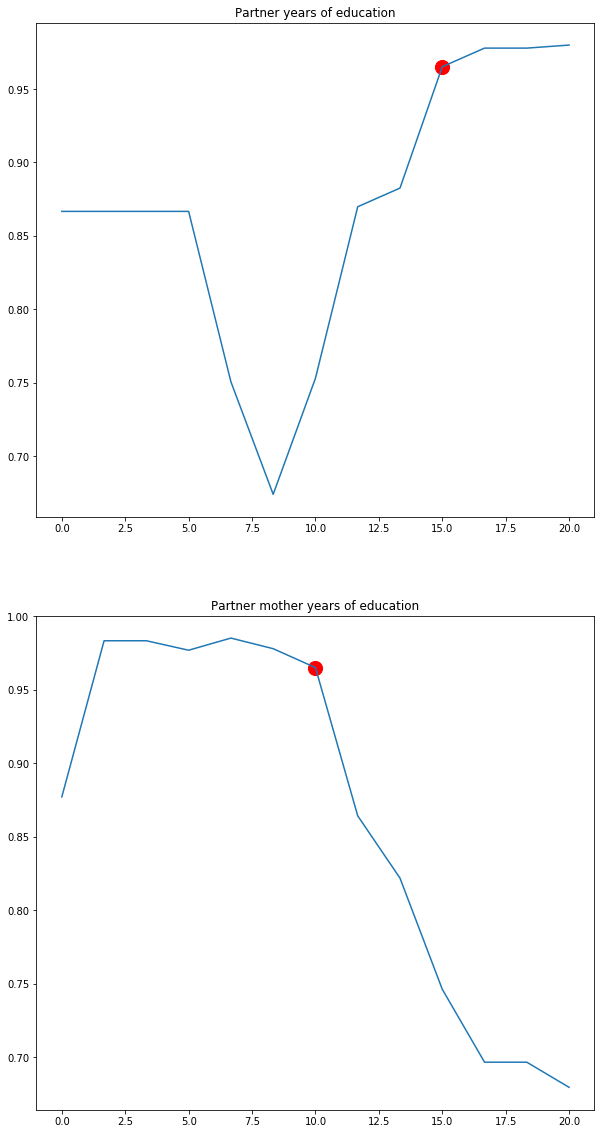

In [7]:
ceteris_paribus(model_xgb, features, ['Partner years of education','Partner mother years of education','meet_in_internet','living_with_partner'], [15.0,10.0,0.0,1.0])